In [1]:
%matplotlib inline
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Reading in GOES-16 NetCDF

In [2]:
g16nc = Dataset('OR_ABI-L1b-RadM1-M3C02_G16_s20171931811268_e20171931811326_c20171931811356.nc', 'r')
radiance = g16nc.variables['Rad'][:]
g16nc.close()
g16nc = None

## Initial Radiance Plot

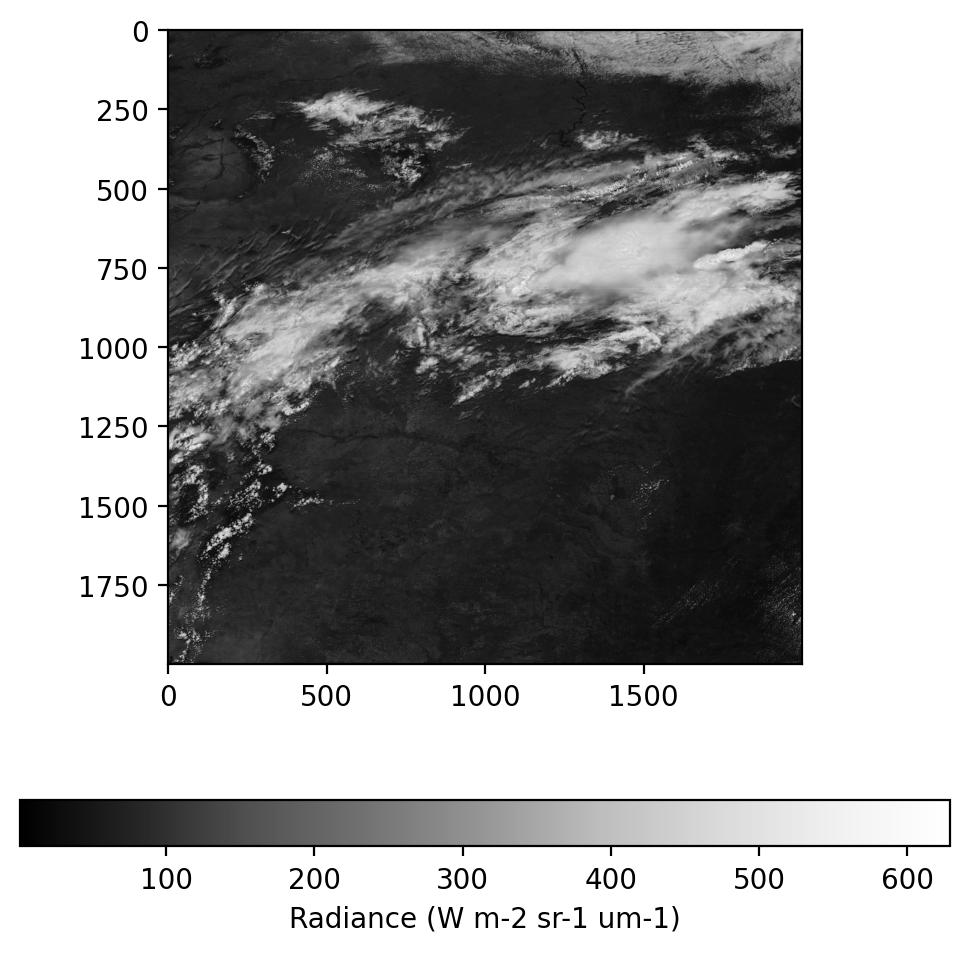

In [3]:
fig = plt.figure(figsize=(6, 6), dpi=200)
im = plt.imshow(radiance, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([1, 100, 200, 300, 400, 500, 600])
cb.set_label('Radiance (W m-2 sr-1 um-1)')
plt.show()

## Radiance to Reflectance

In [4]:
# Define some constants needed for the conversion.
Esun_Ch_01 = 726.721072
Esun_Ch_02 = 663.274497
Esun_Ch_03 = 441.868715
d2 = 0.3

In [5]:
# Apply the formula to convert radiance to reflectance
ref = (radiance * np.pi * d2) / Esun_Ch_02

# Make sure all data is in the valid data range
ref = np.maximum(ref, 0.0)
ref = np.minimum(ref, 1.0)

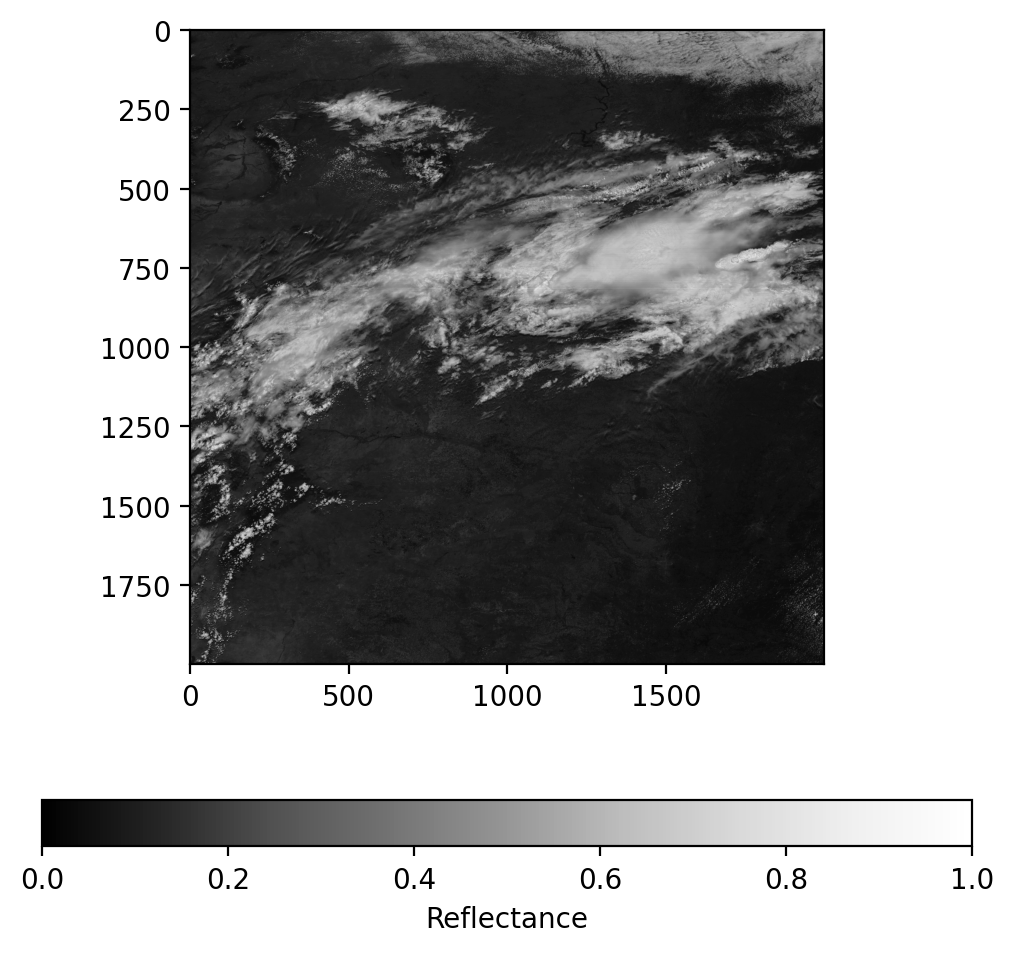

In [6]:
# Plot reflectance
fig = plt.figure(figsize=(6, 6), dpi=200)
im = plt.imshow(ref, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance')
plt.show()

## Gamma correction

The image above looks very dark due to the values are in linear units. We do a simple gamma correction to adjust this and brighten the image.

In [7]:
# Apply the formula to adjust reflectance gamma
ref_gamma = np.sqrt(ref)

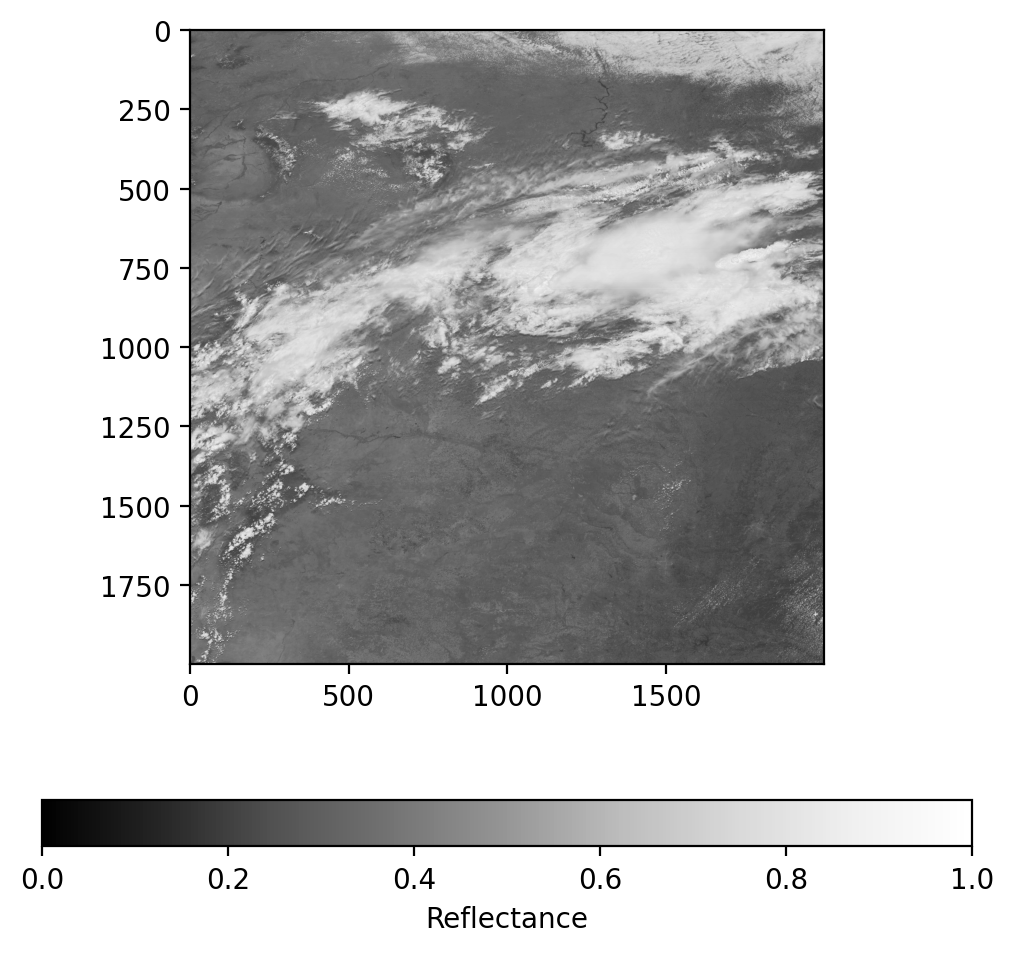

In [8]:
# Plot gamma adjusted reflectance
fig = plt.figure(figsize=(6,6), dpi=200)
im = plt.imshow(ref_gamma, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Reflectance')
plt.show()

## Psuedo-True Color Image

GOES-16 contains a Blue band and a Red band but no Green band. Fortunately, we can derive a linear relationship bbetween the blue, red and veggie (near IR) bands to approximate a green band.

In [9]:
# Load Channel 1 - Blue Visible
g16nc = Dataset('OR_ABI-L1b-RadM1-M3C01_G16_s20171931811268_e20171931811326_c20171931811369.nc', 'r')
radiance_1 = g16nc.variables['Rad'][:]
g16nc.close()
g16 = None
ref_1 = (radiance_1 * np.pi * d2) / Esun_Ch_01

# Make sure all data is in the valid data range
ref_1 = np.maximum(ref_1, 0.0)
ref_1 = np.minimum(ref_1, 1.0)
ref_gamma_1 = np.sqrt(ref_1)

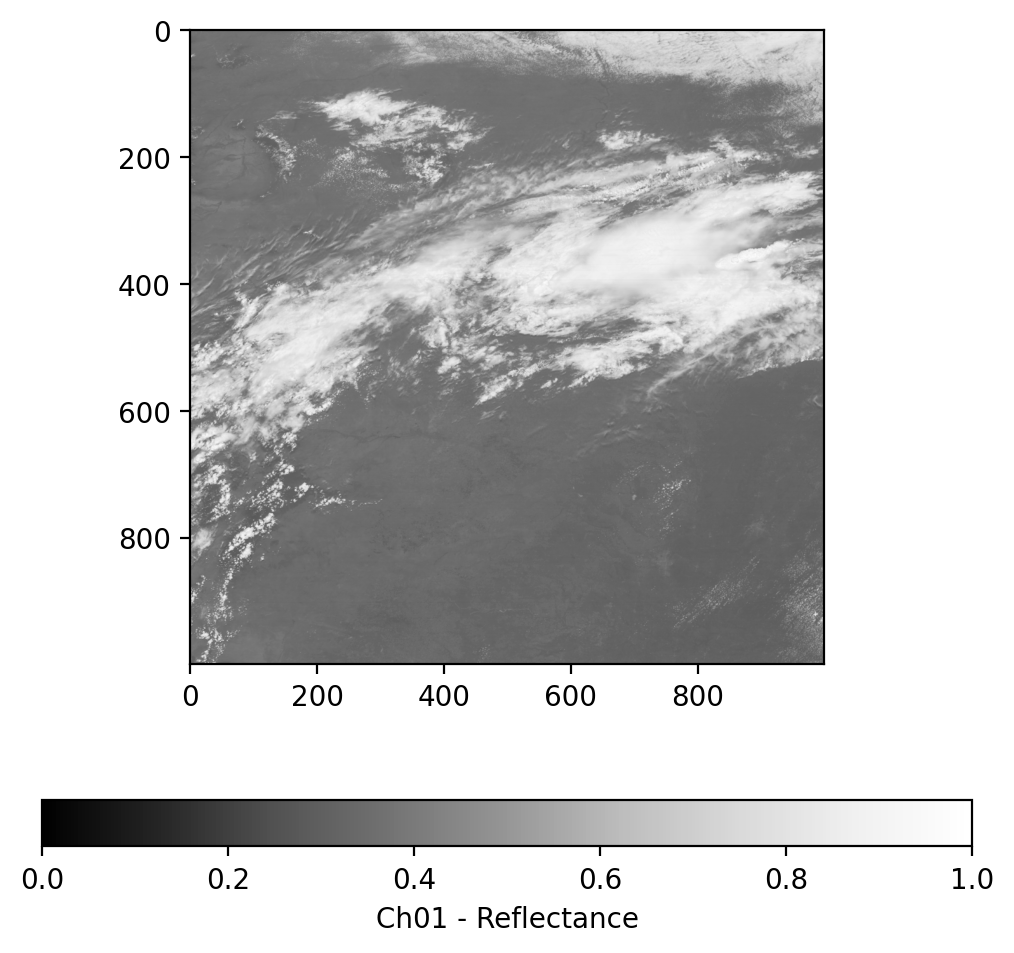

In [10]:
# Plot gamma adjusted reflectance channel 1
fig = plt.figure(figsize=(6, 6), dpi=200)
im = plt.imshow(ref_gamma_1, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch01 - Reflectance')
plt.show()

In [11]:
# Load channel 3 - Veggie Near IR
g16nc = Dataset('OR_ABI-L1b-RadM1-M3C03_G16_s20171931811268_e20171931811326_c20171931811371.nc', 'r')
radiance_3 = g16nc.variables['Rad'][:]
g16nc.close()
g16nc = None
ref_3 = (radiance_3 * np.pi * d2) / Esun_Ch_03

# Make sure all data is in the valid data range
ref_3 = np.maximum(ref_3, 0.0)
ref_3 = np.minimum(ref_3, 1.0)
ref_gamma_3 = np.sqrt(ref_3)

In [ ]:
# Plot gamma adjusted reflectance channel 3
fig = plt.figure(figsize=(6,6), dpi=200)
im = plt.imshow(ref_gamma_3, vmin=0.0, vmax=1.0, cmap='Greys_r')
cb = fig.colorbar(im, orientation='horizontal')
cb.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
cb.set_label('Ch03 - Reflectance')
plt.show()

On GOES-16, Band 2 (Red Visible) is 500-meter resolution while Band 1 (Blue Visible) and Band 3 (Veggie IR) are 1000-meter resolution. In order to combine the 3 bands into an RGB image we will first resample bands 2 to 1000-meter resolution.

In [ ]:
from numpy import mean
def rebin(a, shape):
    sh = shape[0], a.shape[0]//shape[0], shape[1], a.shape[1]//shape[1]
    return a.reshape(sh).mean(-1).mean(1)

In [ ]:
ref_gamma_2 = rebin(ref_gamma, [1000, 1000])

Let's make a geocolor image using the veggie near IR band directly in place of green and see how that looks.

In [ ]:
geocolor = np.stack([ref_gamma_2, ref_gamma_3, ref_gamma_1], axis=2)
fig = plt.figure(figsize=(6, 6), dpi=200)
im = plt.imshow(geocolor)
plt.title('GeoColor - Red - Veggie - Blue')
plt.show()

As you can see, the green channel overpowers everything else. We will use a simple linear relationship to adjust the green vlues to create a psuedo-green channel and produce a better true color image.

In [ ]:
# Derived from Planet Labs data, CC > 0.9
ref_gamma_true_green = 0.48358168 * ref_gamma_2 + 0.45706946 * ref_gamma_1 + 0.06038137 * ref_gamma_3

In [ ]:
truecolor = np.stack([ref_gamma_2, ref_gamma_true_green, ref_gamma_1], axis=2)
fig = plt.figure(figsize=(6, 6), dpi=200)
im = plt.imshow(truecolor)
plt.title('TrueColor - Red - Psuedo-Green - Blue')
plt.show()

## GLM Point Data

The Geostationary Lightning Mapper (GLM) provides point based data of lightning, flashes, groups, and events.

In [ ]:
g16glm = Dataset('OR_GLM-L2-LCFA_G16_s20180471253200_e20180471253400_c20180471253551.nc', 'r')

## GLM Counts

GLM provides latitude longitude points for events (detections) which are then aggregated into group and flash events. Think about how for a single ground strike in a supercell thunderstorm the intracloud portion of the lightning mayextend for many 10s and 100s of miles as the extent of the events. This data is then aggregated to provide cluster centroids which are stored as the flashes.

In [ ]:
event_lat = g16glm.variables['event_lat'][:]
event_lon = g16glm.variables['event_lon'][:]

group_lat = g16glm.variables['group_lat'][:]
group_lon = g16glm.variables['group_lon'][:]

flash_lat = g16glm.variables['flash_lat'][:]
flash_lon = g16glm.variables['flash_lon'][:]

## GLM Plots

In [ ]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=(6, 6), dpi=200)
map = Basemap(projection='merc', lat_0 = 0, lon_0 = -70.0,
             resolution = 'l', area_thresh = 1000.0,
             llcrnrlon = -135.0, llcrnrlat = -65.0,
             urcrnrlon = 0.0, urcrnrlat = 65.0)

map.drawcoastlines()
map.drawcountries()
map.fillcontinents(color = 'tan')
map.drawmapboundary()

# Plot events as large blue dots
event_x, event_y = map(event_lon, event_lat)
map.plot(event_x, event_y, 'bo', markersize=7)

# Plot groups as medium green dots
group_x, group_y = map(group_lon, group_lat)
map.plot(group_x, group_y, 'go', markersize=3)

# Plot flashes as small red dots
flash_x, flash_y = map(flash_lon, flash_lat)
map.plot(flash_x, flash_y, 'ro', markersize=1)